In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# <p style="text-align: center;">Multiclass Image Classification Using CNN</p>

In this notebook I have shown how a simple CNN is implemented on a multiclass image classification problem. I have covered

**1.** How to create a CNN Model and Train it.

**2.** How to evaluate the model on test set using different classification metrics.

**3.** How to visualize the images present in the training and test set.


I hope you find this kernel helpful and some **<span style="color:red">UPVOTES</span>** would be very much appreciated

### **1. Import the Required Libraries**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras import optimizers


### **2. Load the Image Training and Validation Datasets**

#### **i. Get the Image Dataset Paths**

In [3]:
train_dataset_path = '/content/drive/MyDrive/seg_train'
validation_dataset_path = '/content/drive/MyDrive/seg_test'

#### **ii. Load Image Datasets and Apply Augmentations**

Since the images present in the datasets are 150x150px in size, the image height and width are taken as 150, 150 respectively. The batch size value can be changed if required.

In [4]:

IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 32


Loading the training dataset and applying augmentations on it.

In [5]:

train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    shuffle=True)


Found 14044 images belonging to 6 classes.


Loading the validation dataset.

In [6]:

validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)


Found 3012 images belonging to 6 classes.


#### **iii. Get the Label Mappings**

The labels dictionary is made in order to retrive the class names against the label indices used for training the model

In [7]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")


Label Mappings for classes present in the training and validation datasets

0 : buildings
1 : forest
2 : glacier
3 : mountain
4 : sea
5 : street


### **3. Plotting Sample Training Images**

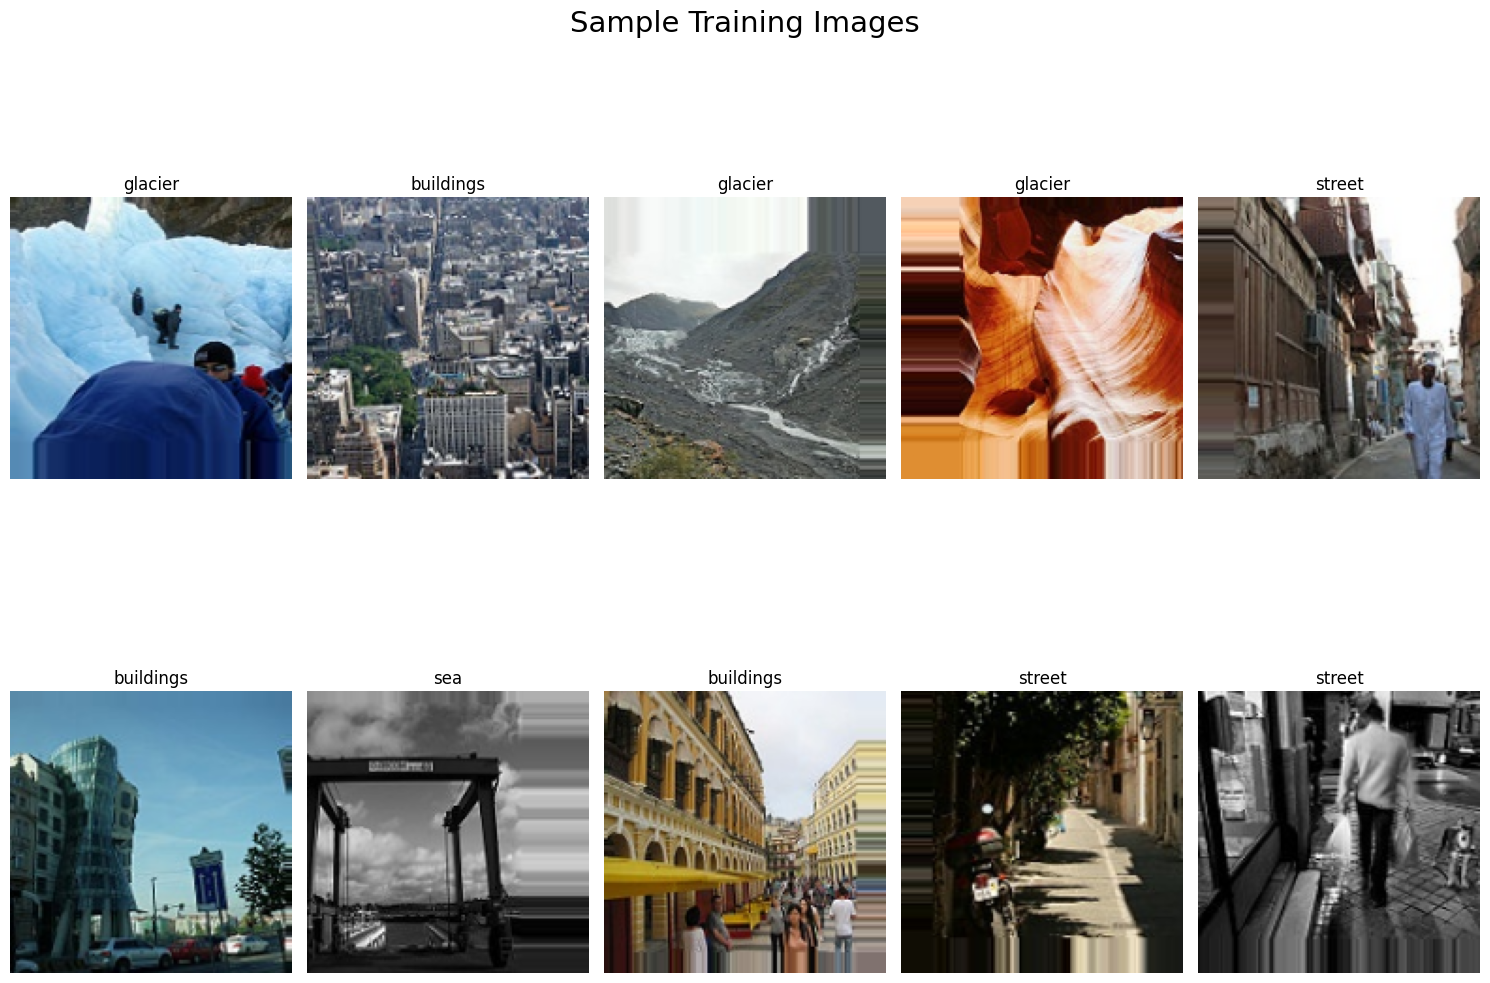

In [8]:

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()


### **4. Training a CNN Model**

In [9]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))








58889256/58889256 [==============================] - 0s 0us/step


In [10]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)
earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 3, verbose = 1, restore_best_weights=True)

In [11]:
# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

In [12]:
# Create a new model by adding custom layers on top of the pre-trained model
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(train_generator.num_classes, activation='softmax'))

In [13]:
# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# Train the model
history = model.fit(train_generator, epochs=5,batch_size=32, validation_data=validation_generator,
                    callbacks=[checkpoint,earlystopping])

Epoch 1/5
439/439 [==============================] - ETA: 0s - loss: 0.7277 - accuracy: 0.7247
Epoch 1: val_loss improved from inf to 0.40950, saving model to model.h5
439/439 [==============================] - 4126s 9s/step - loss: 0.7277 - accuracy: 0.7247 - val_loss: 0.4095 - val_accuracy: 0.8486
Epoch 2/5
439/439 [==============================] - ETA: 0s - loss: 0.5204 - accuracy: 0.8094
Epoch 2: val_loss improved from 0.40950 to 0.37925, saving model to model.h5
439/439 [==============================] - 158s 359ms/step - loss: 0.5204 - accuracy: 0.8094 - val_loss: 0.3793 - val_accuracy: 0.8579
Epoch 3/5
439/439 [==============================] - ETA: 0s - loss: 0.4728 - accuracy: 0.8258
Epoch 3: val_loss improved from 0.37925 to 0.34813, saving model to model.h5
439/439 [==============================] - 150s 341ms/step - loss: 0.4728 - accuracy: 0.8258 - val_loss: 0.3481 - val_accuracy: 0.8715
Epoch 4/5
439/439 [==============================] - ETA: 0s - loss: 0.4354 - accurac

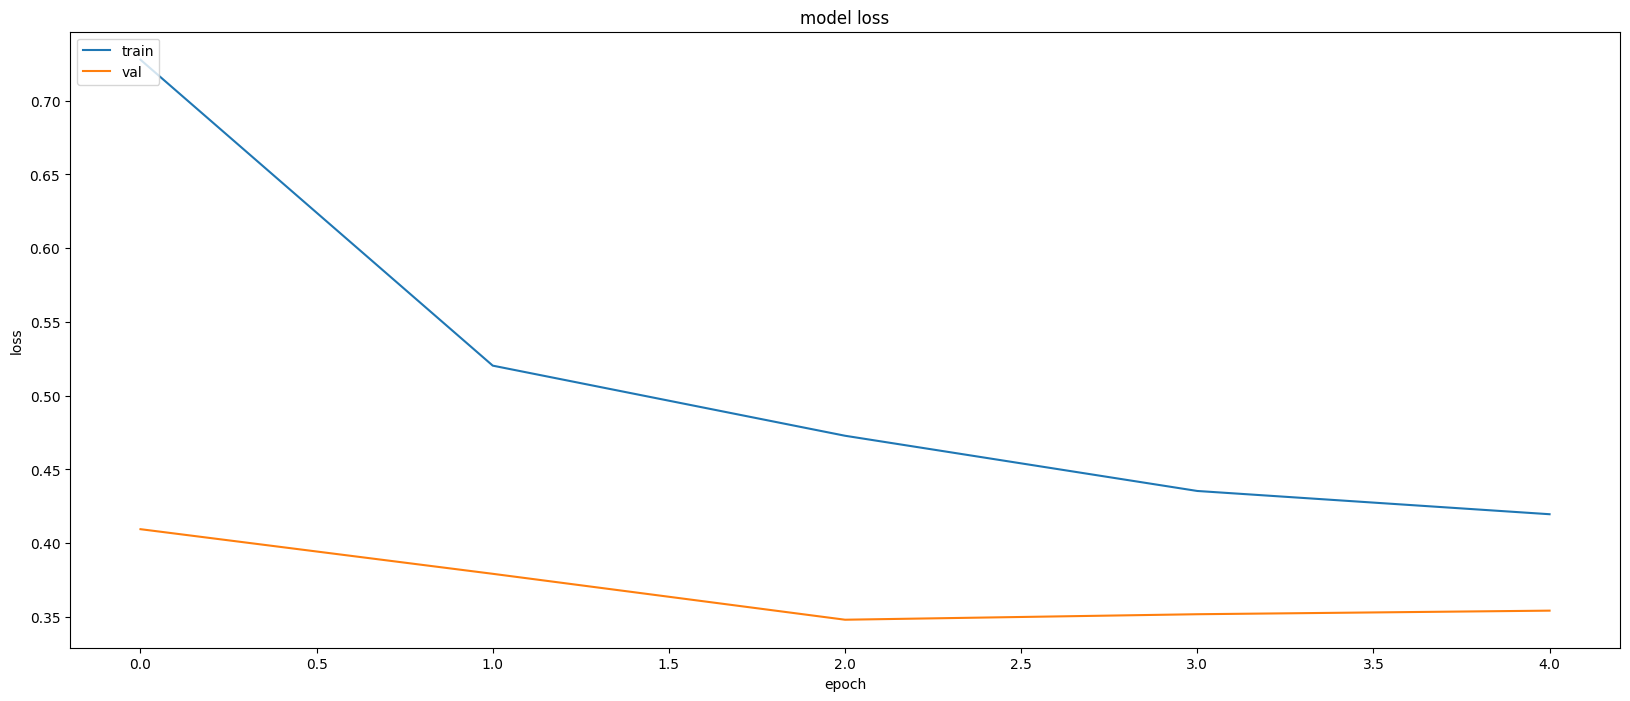

In [16]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

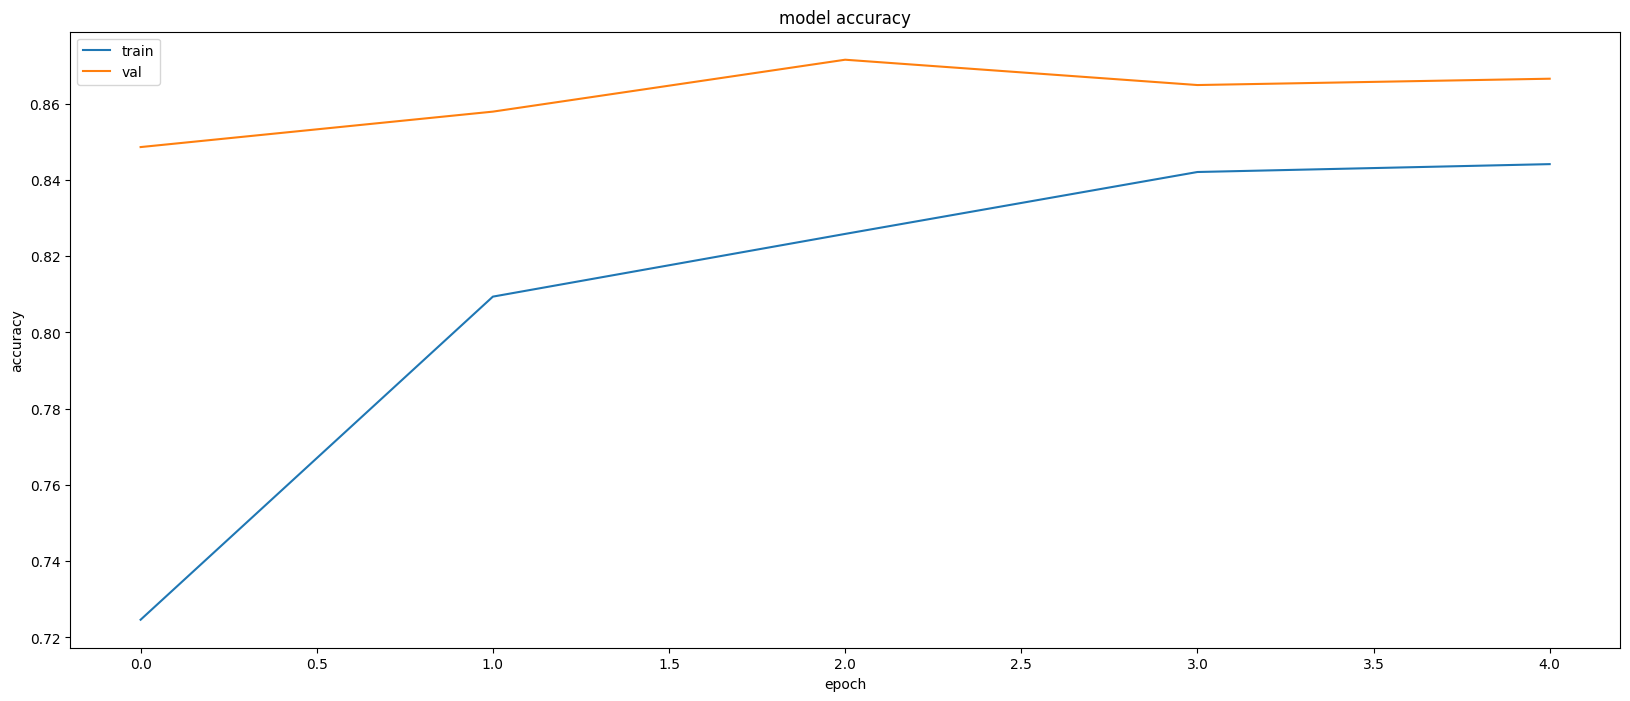

In [17]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
